In [1]:
## Import libraries
#general
import pandas as pd
import os
import numpy as np
from sklearn import tree
import graphviz
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import scipy.stats as stats
import re
from sklearn.externals.six import StringIO


#visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

In [2]:
## Read in data
data = pd.read_csv('monster_com-job_sample.csv')
data.columns

Index([u'country', u'country_code', u'date_added', u'has_expired',
       u'job_board', u'job_description', u'job_title', u'job_type',
       u'location', u'organization', u'page_url', u'salary', u'sector',
       u'uniq_id'],
      dtype='object')

In [3]:
## Parse salary data and prepare dataset
#data['numbers']=''
data['yearly'] = ''
data['hourly'] =''
data['full_time']=''
data['part_time']=''
data['analyst']=''

for index in data.salary.index:

    #data['numbers'][index]=bool(re.match(r'([0-9]+[^0-9]+)',str(data.salary[index])))
    data['yearly'][index]=bool(re.search('\$ /year',str(data.salary[index])))
    data['hourly'][index]=bool(re.search('\$ /hour',str(data.salary[index])))
    data['full_time'][index]=bool(re.search('Full Time',str(data.job_type[index])))
    data['part_time'][index]=bool(re.search('(part)|(Part)',str(data.job_type[index])))
    data['analyst'][index]=bool(re.search('(analyst)|(Analyst)',str(data.job_title[index])))

#extract salary ranges
ranges=data.salary.str.extract(r'([0-9\.\,\s]+.\-[0-9\.\,\s]+)',expand=True).rename(columns={0:'ranges'})
data=data.join(ranges)

#extract numbers
numbers=data.salary.str.extract(r'([0-9]+\s)',expand=True,).rename(columns={0:'numbers'})
data=data.join(numbers)

#parse salary ranges
df=data['ranges'].str.split('-',expand=True).rename(columns={0:'lowest',1:'highest'})
data=data.join(df)

#convert columns to numeric
numeric=pd.Index([u'lowest',u'highest',u'numbers'])

for i in numeric:
    data[i]=data[i].str.replace(' ','')
    data[i]=data[i].str.replace(',','')
    data[i]=pd.to_numeric(data[i])





In [4]:
#convert units of hours into units of years
for index in data.salary.index:
        for i in numeric:
            if (data.hourly[index]==True):
                if(data.part_time[index]==False):
                    data[i][index]=data[i][index]*40*52
                else:
                   data[i][index]=data[i][index]*20*52

/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
#get midpoint data for ranges
data['midpoint_salary']=(data['lowest']+data['highest'])/2

#add non-range salaries to midpoints column
for index in data.salary.index:
    if(pd.isnull(data.ranges[index])&pd.notnull(data.numbers[index])):
        data.midpoint_salary[index]=data.numbers[index]

In [2]:
#write cleaned data to csv
data.to_csv('monster_com-job_sample_cleaned.csv')

NameError: name 'data' is not defined

In [195]:
data=pd.read_csv('monster_com-job_sample_cleaned.csv')
#remove nan's
data=data.dropna(subset=['midpoint_salary'])
#only yearly and hourly salary
data=data[data.yearly|data.hourly]

In [196]:
#only include non-bogus salaries. The lowest possible minimum wage job in the US pays at least $7/hour
part_time_min=7*20*52
full_time_min=7*40*52

# filter out any salaries lower than $7/hour
data=data[((data.lowest>=part_time_min)&(data.highest>=part_time_min)&(data.part_time==True))|((data.lowest>=full_time_min)&(data.highest>=full_time_min)&(data.part_time==False))]

# filter out any salaries larger than $9,000,000 a year. Jobs claiming to pay more than that on a job board site would be a bit suspect.
data=data[data.highest<=9000000]

# filter out only salaries in the US, our country of interest.
data=data[data.country_code=='US']

# filter out only full time salaries, as these are what interests us
data=data[data.part_time==False]

# make states column
states=r'(AK|AL|AR|AZ|CA|CO|CT|DE|FL|GA|HI|IA|ID|IL|IN|KS|KY|LA|MA|MD|ME|MI|MN|MO|MS|MT|NC|ND|NE|NH|NJ|NM|NV|NY|OH|OK|OR|PA|RI|SC|SD|TN|TX|UT|VA|VT|WA|WI|WV|WY)'

state=data.location.str.extract(states,expand=True,).rename(columns={0:'state'})
data=data.join(state)



In [197]:
#fix sector information
i='sector'

data['sector']=data['sector'].str.replace(' ','')
data['sector']=data['sector'].str.replace(',','')


In [198]:
#check min and max salaries
print('max:',data.midpoint_salary.max())
print('min:',data.midpoint_salary.min())
#data.sort_values(by='midpoint_salary',ascending=False)

('max:', 945360.0)
('min:', 15600.0)


In [199]:
# remove data point 7194, as it is highly unlikely that a picker/packer makes $900/hour
data=data.drop(7194)

#remove na values
data=data[pd.notnull(data.sector)|pd.notnull(data.state)]

In [200]:
## Prepare data for linear model and run

#onehotencode variables using dummies and separate out dependent and independent features
df=pd.get_dummies(data[['state','sector']],drop_first=False)
y=data['midpoint_salary']

#split into training and test set
X_train_1, X_test_1, y_train_1,y_test_1 = train_test_split(df,y,test_size=.22)

#run model
lm=LinearRegression()
lm.fit(X_train_1,y_train_1)

print('coefficient: ',lm.coef_)
print('intercept: ',lm.intercept_) 
y_pred_test=lm.predict(X_test_1)



print("Training set RMSE:",np.sqrt(metrics.mean_squared_error(y_test_1, y_pred_test)))

coefficients = pd.concat([pd.DataFrame(df.columns),pd.DataFrame(np.transpose(lm.coef_))], axis = 1)
coefficients


('coefficient: ', array([ -2.93548182e+03,   2.05359574e+03,  -2.98798415e+04,
        -1.69443437e+03,  -1.30815556e+04,   4.26083423e+03,
         7.81376059e+03,  -2.16749559e+04,  -3.01804213e+04,
        -1.18351069e+04,   5.84674862e+04,   2.38563659e+03,
        -2.01640556e+04,  -9.74623192e+03,  -7.57235798e+03,
        -1.27123673e+04,   1.89823449e+04,  -1.30899295e+04,
        -3.17067924e+03,  -2.46917043e+03,  -3.52281481e+03,
        -1.45709796e+04,  -6.74081064e+03,  -9.02708140e+04,
         1.32966883e+04,   4.13467382e+04,  -3.64212618e+04,
        -1.82648805e+04,   2.54684000e+03,   1.07610751e+04,
        -6.81556626e+02,   7.83081816e+03,  -1.52161428e+04,
        -1.91112908e+04,  -2.62534785e+04,  -1.12688069e+04,
         3.33625771e+03,  -1.23890014e+04,  -3.32525138e+04,
        -2.71779539e+04,  -3.09979676e+03,  -7.05268536e+03,
        -2.07583863e+03,  -6.51714523e+03,  -1.26023866e+04,
        -1.08511322e+04,   2.68558658e+04,  -1.92799141e+03,
      

,0,0
0,state_AL,-2.935482e+03
1,state_AR,2.053596e+03
2,state_AZ,-2.987984e+04
3,state_CA,-1.694434e+03
4,state_CO,-1.308156e+04
5,state_CT,4.260834e+03
6,state_DE,7.813761e+03
7,state_FL,-2.167496e+04
8,state_GA,-3.018042e+04
9,state_IA,-1.183511e+04


Some of the sector features seem to not be sectors at all (e.g. CareerLevelEntryLevel). This confuses the dataset, as I  we do not have good information for this on every job posting. I will remove this and other offending rows to see if there will be an improvement.

In [202]:
# only include analyst positions
data2=data[data.analyst==True]


In [215]:
# onehotencode variables using dummies and separate out dependent and independent features
df2=pd.get_dummies(data2[['state','sector']],drop_first=True)
y=data2['midpoint_salary']

# Split into training and test set
X_train, X_test, y_train,y_test = train_test_split(df2,y,test_size=.22)

# run model
lm=LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [223]:
# Check the model
y_pred_test=lm.predict(X_test)
print("Training set RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

('Training set RMSE:', 1.2772191543594046e+17)


The model is still waaaaaaay off. It seems that number of features is roughly equal to the number of rows. Imputing values is not a good option, since the majority of the dataset is missing plausible values for the thing we want to predict, i.e. salary. If I want to do an analysis for analyst only positions, I may need to get a bigger dataset with more positions. 

Also, since there are  only categorical variables here, perhaps linear regression doesn't make sense. Let's try decision trees.

('Decision Tree RMSE:', 50792.984195320598)


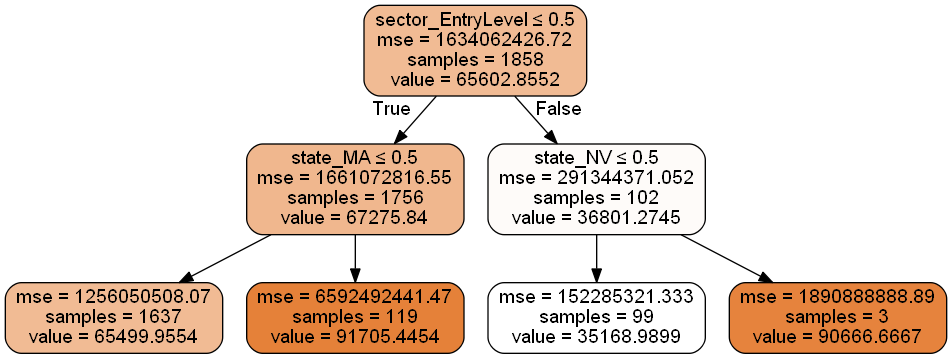

In [218]:
## Use a decision tree to look at what variables are most important
#use the same train/test split to run a decision tree
decision_tree = DecisionTreeRegressor(max_depth=2, random_state=2)
decision_tree.fit(X_train_1,y_train_1)
print("Decision Tree RMSE:",np.sqrt(metrics.mean_squared_error(y_test_1,decision_tree.predict(X_test_1))))

#This allows us to make a decision tree real fast directly in the notebook!
dot_data = StringIO()  
export_graphviz(decision_tree, out_file=dot_data,  
                    feature_names=X_train_1.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

('Decision Tree Train/Test RMSE:', 39823.081512617457, ' ', 51301.181085353623)
('Decision Tree Train/Test RMSE:', 39243.452250354989, ' ', 50792.984195320591)
('Decision Tree Train/Test RMSE:', 38560.946870660424, ' ', 50408.8254114952)
('Decision Tree Train/Test RMSE:', 38001.106823876806, ' ', 50508.344943675998)
('Decision Tree Train/Test RMSE:', 37569.180743939862, ' ', 50324.948391172577)
('Decision Tree Train/Test RMSE:', 37158.144926587272, ' ', 50562.205571394603)
('Decision Tree Train/Test RMSE:', 36704.660989830765, ' ', 50656.139851573069)
('Decision Tree Train/Test RMSE:', 36238.137609552003, ' ', 50377.118390291726)
('Decision Tree Train/Test RMSE:', 36029.384010784888, ' ', 50250.797639415367)


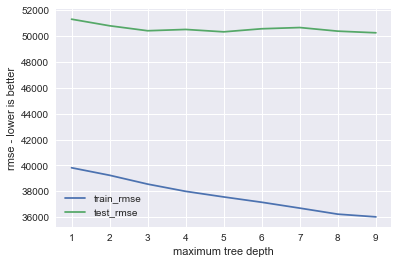

In [219]:
depths = range(1,10)
train_rmse, test_rmse = [],[]
for depth in depths:
    decision_tree = DecisionTreeRegressor(max_depth=depth,random_state=10)
    decision_tree.fit(X_train_1,y_train_1)
    curr_train_rmse = np.sqrt(metrics.mean_squared_error(y_train_1,decision_tree.predict(X_train_1)))
    curr_test_rmse = np.sqrt(metrics.mean_squared_error(y_test_1,decision_tree.predict(X_test_1)))
    print("Decision Tree Train/Test RMSE:",curr_train_rmse," ",curr_test_rmse)
    train_rmse.append(curr_train_rmse)
    test_rmse.append(curr_test_rmse)
sns.mpl.pyplot.plot(depths,train_rmse,label='train_rmse')
sns.mpl.pyplot.plot(depths,test_rmse,label='test_rmse')
sns.mpl.pyplot.xlabel("maximum tree depth")
sns.mpl.pyplot.ylabel("rmse - lower is better")
sns.mpl.pyplot.legend()

The RMSE is several orders of magnitude lower when using decision trees as compared to linear regression. Therefore, it could be that it's a better fit for this dataset. However, the rmse is still pretty large. The decision tree turned up something in the data, however. It seems that there are some values for sector that are not actually sectors (e.g. EntryLevel). I will remove these offending rows, and compare the results of linear regression and decision trees.

C:\Users\daherg\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


('Decision Tree RMSE:', 40074.488349392435)


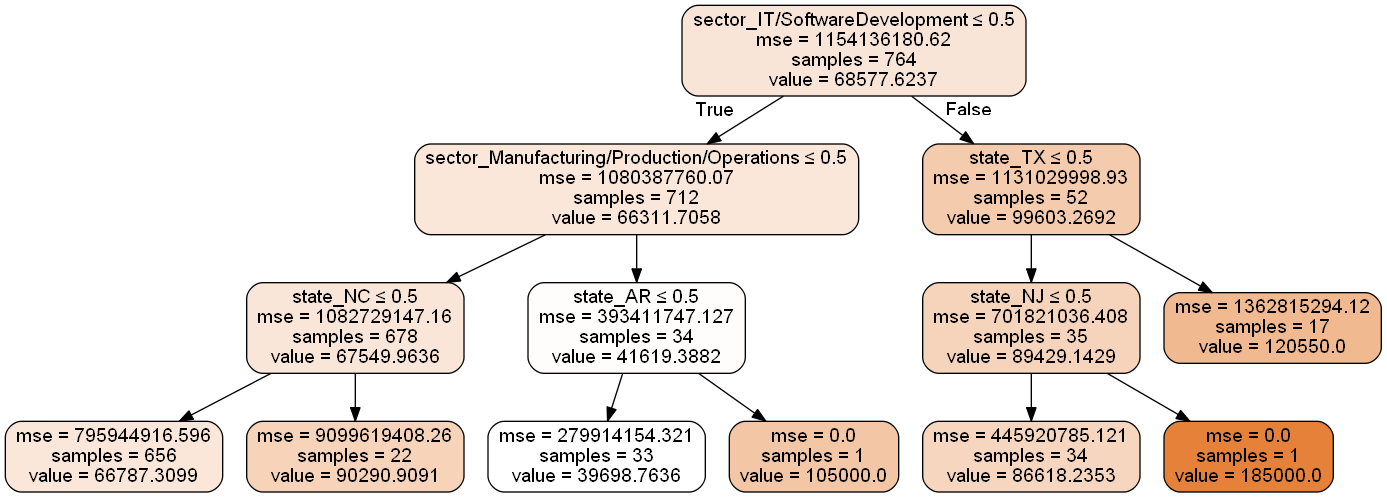

In [230]:
#remove the offending values from the dataset
data_cleaned=data[pd.notnull(data.sector)&pd.notnull(data.state)]
data_cleaned=data_cleaned[(data_cleaned.sector!='Executive(SVPVPDepartmentHeadetc)')&(data_cleaned.sector!='Other')&(data_cleaned.sector!='EntryLevel')& (data_cleaned.sector!="Student(Undergraduate/Graduate)" )& (data_cleaned.sector!="Student(HighSchool)")& (data_cleaned.sector!="CareerLevelExperienced(Non-Manager)")& (data_cleaned.sector!="CareerLevelEntryLevel")&(data.sector!='Experienced(Non-Manager)')]

#re-run the model

# Try the model using upper and lower ranges rather than midpoint
df3=pd.get_dummies(data_cleaned[['state','sector']],drop_first=True)


y2=data_cleaned['midpoint_salary']

# Split into training and test set
X_train_2, X_test_2, y_train_2,y_test_2 = train_test_split(df3,y2,test_size=.22)

decision_tree = DecisionTreeRegressor(max_depth=3, random_state=2)
decision_tree.fit(X_train_2,y_train_2)
print("Decision Tree RMSE:",np.sqrt(metrics.mean_squared_error(y_test_2,decision_tree.predict(X_test_2))))

#This allows us to make a decision tree real fast directly in the notebook!
dot_data = StringIO()  
export_graphviz(decision_tree, out_file=dot_data,  
                    feature_names=X_train_2.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [227]:
#linear regression
lm=LinearRegression()
lm.fit(X_train_2,y_train_2)
y_pred_test=lm.predict(X_test_2)
print("Training set RMSE:",np.sqrt(metrics.mean_squared_error(y_test_2, y_pred_test)))

('Training set RMSE:', 1.1350257743206845e+17)


Still little improvement in the linear regression model. Let's try Ridge regression, in the case of colinear variables

In [228]:
# Try ridge regression for colinear variables
clf=Ridge()
clf.fit(X_train_2,y_train_2)
y_pred_test=clf.predict(X_test_2)
print("Training set RMSE:",np.sqrt(metrics.mean_squared_error(y_test_2, y_pred_test)))

('Training set RMSE:', 37978.532186682736)


This last model, with ridge reduction, seems to work the best of all. Lets do cross validaiton to get the best possible model.

In [264]:
#ridge reduction with cross validation and a holdout set
clf_cv=RidgeCV()
df=pd.get_dummies(data_cleaned[["state","sector"]])
y=data_cleaned["midpoint_salary"]
X_train_3, X_test_3, y_train_3,y_test_3 = train_test_split(df,y,test_size=.2)
clf_cv.fit(df,y)
y_pred_test=clf_cv.predict(X_test_3)
print("Training set RMSE:",np.sqrt(metrics.mean_squared_error(y_test_3, y_pred_test)))

('Training set RMSE:', 28175.508751905923)


In [265]:
data_cleaned.shape

(980, 26)

Cross Validation with Ridge reduction seems to work the best of all models so far. However, I need to work on getting more data. We started off with roughtly 22,000 lines of data, but had to filter out most of it due to the poor data quality. A beter method might be to use tokenization and clustering techniques to get sector data. I am also in the process of figuring out how to webscrape indeed.com for more data. 

My original intent was to use logistic regression to predict salary ranges. However, the ranges don't seem standardized (they overlap). Rather than ranges, I used the salary midpoint because I thought it would be cleaner. Thus, I decided to use logistic regression in stead.